In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils_data import x_y_split , data_splitter
from utils_lgbm import lgbm_train_val_test_split_original
from lgbm_data_prep import LgbmDataPrep
from sklearn.pipeline import Pipeline, FeatureUnion
import numpy as np
import pandas as pd
from typing import List

### Split To Original train and test

In [3]:
x,v,t = lgbm_train_val_test_split_original()

### split to X, y 

In [4]:
X, y = x_y_split(x,'anomaly')
X_test, y_test = x_y_split(t,'anomaly')

In [5]:
config = {
    'look_back': 10,
    'num_splits': 5
}

In [6]:
feature_pipe, targets_pipe =  LgbmDataPrep(**config).run()

In [7]:
feature_pipe

Pipeline(steps=[('transformations',
                 FeatureUnion(transformer_list=[('part_0',
                                                 Pipeline(steps=[('drop_changepoint',
                                                                  DropColumnTransformer(columns_to_drop=['changepoint'])),
                                                                 ('smooth',
                                                                  SmoothCurve()),
                                                                 ('scaler',
                                                                  StandardScaler()),
                                                                 ('df_creator',
                                                                  CreateStatsDataframe()),
                                                                 ('classifier',
                                                                  <lgbm_model.LgbmModel object at 0x133721990>)])),
                                                ('part_1',
                                                 Pipeline(steps=[('dro...
                                                                 ('classifier',
                                                                  <lgbm_model.LgbmModel object at 0x133722c80>)])),
                                                ('part_4',
                                                 Pipeline(steps=[('drop_changepoint',
                                                                  DropColumnTransformer(columns_to_drop=['changepoint'])),
                                                                 ('smooth',
                                                                  SmoothCurve()),
                                                                 ('scaler',
                                                                  StandardScaler()),
                                                                 ('df_creator',
                                                                  CreateStatsDataframe()),
                                                                 ('classifier',
                                                                  <lgbm_model.LgbmModel object at 0x133723df0>)]))])),
                ('processing_results', AggregateModelScores())])

In [8]:
y = targets_pipe.fit_transform(y)
feature_pipe.fit(X,y)

[LightGBM] [Info] Number of positive: 803, number of negative: 1737
[LightGBM] [Info] Total Bins 6105
[LightGBM] [Info] Number of data points in the train set: 2540, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.316142 -> initscore=-0.771560
[LightGBM] [Info] Start training from score -0.771560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 742, number of negative: 1798
[LightGBM] [Info] Total Bins 6116
[LightGBM] [Info] Number of data points in the train set: 2540, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.292126 -> initscore=-0.885081
[LightGBM] [Info] Start training from score -0.885081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

Pipeline(steps=[('transformations',
                 FeatureUnion(transformer_list=[('part_0',
                                                 Pipeline(steps=[('drop_changepoint',
                                                                  DropColumnTransformer(columns_to_drop=['changepoint'])),
                                                                 ('smooth',
                                                                  SmoothCurve()),
                                                                 ('scaler',
                                                                  StandardScaler()),
                                                                 ('df_creator',
                                                                  CreateStatsDataframe()),
                                                                 ('classifier',
                                                                  <lgbm_model.LgbmModel object at 0x133721990>)])),
                                                ('part_1',
                                                 Pipeline(steps=[('dro...
                                                                 ('classifier',
                                                                  <lgbm_model.LgbmModel object at 0x133722c80>)])),
                                                ('part_4',
                                                 Pipeline(steps=[('drop_changepoint',
                                                                  DropColumnTransformer(columns_to_drop=['changepoint'])),
                                                                 ('smooth',
                                                                  SmoothCurve()),
                                                                 ('scaler',
                                                                  StandardScaler()),
                                                                 ('df_creator',
                                                                  CreateStatsDataframe()),
                                                                 ('classifier',
                                                                  <lgbm_model.LgbmModel object at 0x133723df0>)]))])),
                ('processing_results', AggregateModelScores())])

In [9]:
res = feature_pipe.transform(X_test)
y_pred = res['avg_prediction'].copy()

X.shape:  (1844, 5)


In [10]:
res

,model_0,model_1,model_2,model_3,model_4,avg_prediction,median_prediction,max_prediction
0,0.005014,0.004171,0.010477,0.005018,0.004507,0.005837,0.005016,0.010477
1,0.005014,0.004171,0.010477,0.005018,0.004507,0.005837,0.005016,0.010477
2,0.005014,0.004171,0.005770,0.005018,0.004507,0.004896,0.004955,0.005770
3,0.005014,0.004171,0.005770,0.005018,0.004507,0.004896,0.004955,0.005770
4,0.005014,0.004171,0.005778,0.005018,0.004507,0.004898,0.004956,0.005778
...,...,...,...,...,...,...,...,...
1839,0.005858,0.004171,0.090590,0.004860,0.006959,0.022488,0.006409,0.090590
1840,0.005858,0.004171,0.084058,0.004883,0.006959,0.021186,0.006409,0.084058
1841,0.005858,0.004171,0.129002,0.004968,0.006959,0.030192,0.006409,0.129002
1842,0.005858,0.004169,0.129002,0.005080,0.006959,0.030214,0.006409,0.129002


In [11]:
### Evaluation

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

In [13]:
def calc_metrics(y_true,y_pred):
    th = 0.35
    accuracy = accuracy_score(y_true, np.where(y_pred>=th,1,0))
    cm = confusion_matrix(y_true, np.where(y_pred>=th,1,0))
    f1 = f1_score(y_true, np.where(y_pred>=th,1,0))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return accuracy,cm,f1,fpr, tpr, thresholds, roc_auc

def plot_metrics(cm, fpr, tpr, roc_auc, thresholds, title = 'Model Evaluation Metrics'):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    fig.suptitle(title, fontsize=16, y=1.02)
    confusion_matrix_ax = ax[0]
    roc_curve_ax = ax[1]

    # Confusion Matrix in the first subplot
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=confusion_matrix_ax,cmap='Blues')
    confusion_matrix_ax.set_title('Confusion Matrix')
    confusion_matrix_ax.set_xlabel('Predicted labels')
    confusion_matrix_ax.set_ylabel('True labels')

    # ROC Curve in the second subplot
    roc_curve_ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    roc_curve_ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    roc_curve_ax.set_xlabel('False Positive Rate')
    roc_curve_ax.set_ylabel('True Positive Rate')
    roc_curve_ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    roc_curve_ax.legend(loc='lower right')
    # Display the plot
    plt.tight_layout()
    plt.show()

In [14]:
y_test1 = targets_pipe.transform(y_test)

In [15]:
y_pred.shape

(1844,)

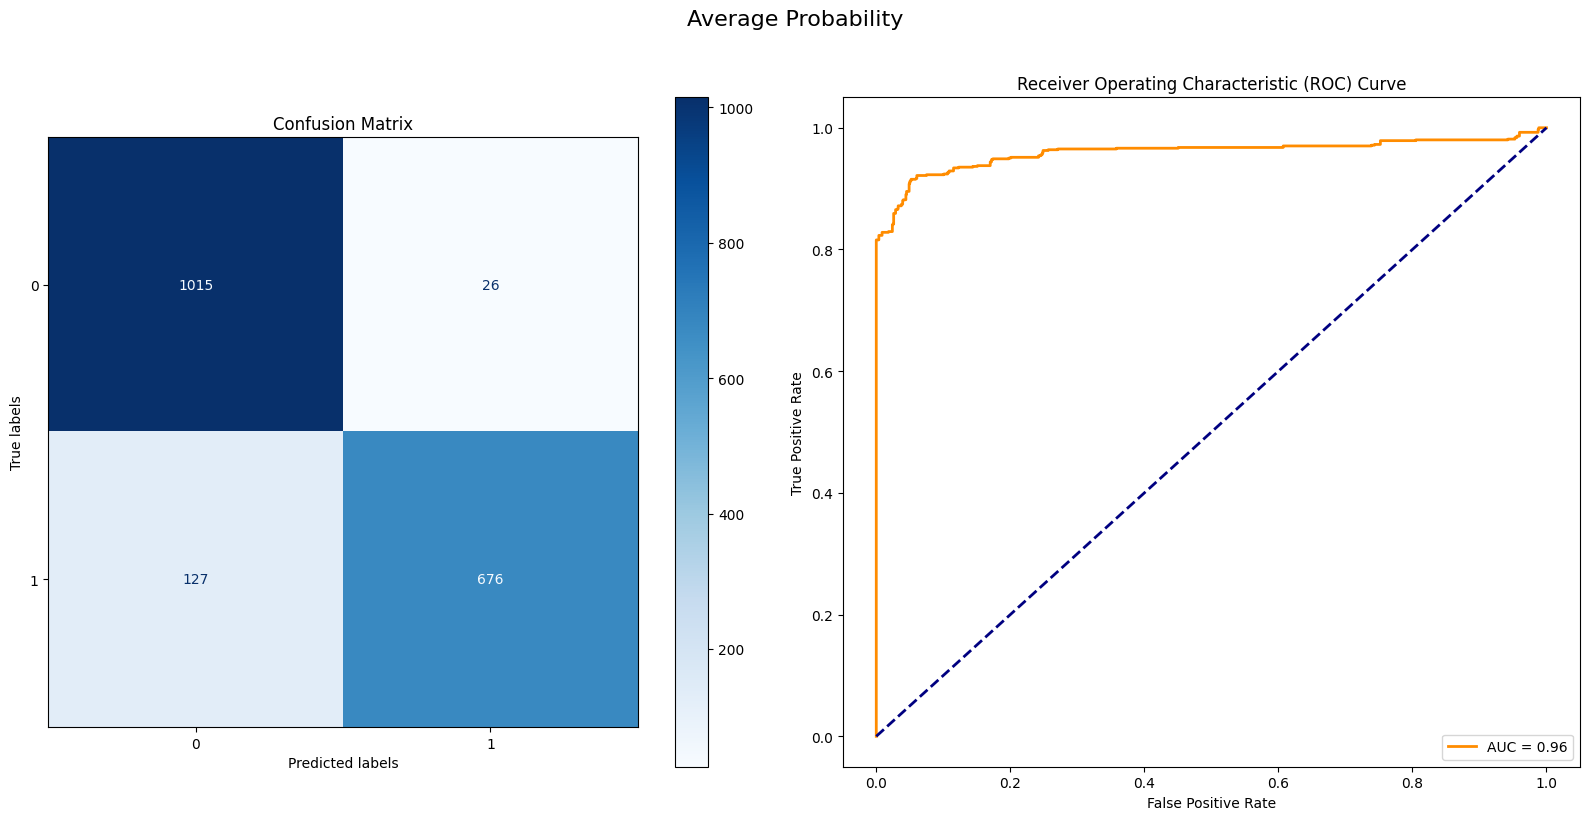

In [16]:
accuracy, cm, f1, fpr, tpr, thresholds, roc_auc = calc_metrics(y_test1,y_pred)
plot_metrics(cm, fpr, tpr, roc_auc, thresholds, title = 'Average Probability')